ECE 228 ML For Physical Applications
Final Project - Jonathan Cremonesi

Implementing a single‐output LSTM (MSE loss) with softplus activation, a hard low‑irradiance fallback, plus rolling‑window cross‑validation and hyperparameter tuning of LSTM layers, units, dropout, and learning rate—all in one pipeline.

Point-Forecast LSTM (MSE-Trained) Overview

Model Purpose:
This model provides a 24-hour-ahead photovoltaic (PV) power forecast for an 84 kW system. It produces a single “best-guess” output for each of the next 24 hours without any uncertainty band.

Data and Inputs:
• Lookback window: 24 hours of lagged features (ERA5 NWP variables plus calendar encodings).
• Features (12 total):
– Solar irradiance: global horizontal “G(i)”, beam normal “Gb(n)”, diffuse horizontal “Gd(h)”.
– Meteorological: temperature “T2m”, relative humidity “RH”, wind speed “WS10m”, wind direction “WD10m”, sea-level pressure “SP”.
– Cyclic time features: hour_sin, hour_cos, day_sin, day_cos (encode hour of day and day of year).

Model Architecture:

Input layer accepts a 24×12 matrix (24 time steps, 12 features per step).

One LSTM layer with 50 units (return_sequences=False).

Dense output layer with 24 units (one per forecast hour), using a softplus activation to enforce non-negative outputs.

The final output is a 24-length vector giving the point forecast (in scaled units) for hours t+1 through t+24.

Training Details:
• Loss function: Mean Squared Error (MSE) on MinMax-scaled PV values.
• Optimizer: Adam with learning rate = 0.001.
• Metric: Mean Absolute Error (MAE) on scaled PV (used for early stopping).
• Early stopping: monitor validation loss, patience = 3 epochs, with ’restore_best_weights’ set to True.
• Data split: static 80% train / 20% validation using the last 20% of available 2023 samples.

Preprocessing and Scaling:
• MinMax scale all input features to [0,1] using scaler_X.
• MinMax scale the target PV sequence (24-hour block) to [0,1] using scaler_y.
• After inference, inverse-transform predicted PV back to Watts via scaler_y.

Low-Irradiance Fallback Logic:
• If G(i) < 50 W/m² (dawn or dusk conditions), override the LSTM forecast with a linear rule: PV_fallback = 84 W per 1 W/m² × G(i).
• If G(i) = 0 W/m², set PV = 0 W.

Point‐Forecast LSTM (MSE‐Trained) Detailed Architecture and Process

Data Pipeline and Preprocessing:
1. Data Source: Hourly PV generation data (“P” in W) for an 84 kW system plus ERA5‐based NWP variables (hourly) from Jan 1 2023–Dec 31 2023.
2. Timestamp Alignment: Original PV measurements recorded at xx:30 past the hour. NWP data provided on the hour—shift NWP timestamps by +30 minutes to align with PV measurements.
3. Feature Engineering (12 features per timestamp):
   • G(i) = Global horizontal irradiance (W/m²)
   • Gb(n) = Beam normal direct irradiance (W/m²)
   • Gd(h) = Diffuse horizontal irradiance (W/m²)
   • T2m = 2 m air temperature (°C)
   • RH = Relative humidity (%)
   • WS10m = 10 m wind speed (m/s)
   • WD10m = 10 m wind direction (degrees)
   • SP = Mean sea‐level pressure (hPa)
   • hour_sin = sin(2π × (hour_of_day / 24))
   • hour_cos = cos(2π × (hour_of_day / 24))
   • day_sin = sin(2π × (day_of_year / 365))
   • day_cos = cos(2π × (day_of_year / 365))
4. Sequence Construction (X_seq, y_seq):
   • lookback = 24. For each index i from 0 to N_total – 24 – 24, form X_seq[i] = features[i : i+24], y_seq[i] = PV[i+24 : i+24+24].
   • X_seq shape = (N_samples, 24, 12). y_seq shape = (N_samples, 24).
   • Each y_seq[i,j] corresponds to PV at timestamp i+24+j (in W).
5. Train/Validation Split:
   • Static 80/20 split on sequence index: split_idx = int(0.8 × N_samples).
   • X_train = X_seq[0:split_idx], X_val = X_seq[split_idx:], same for y_train, y_val.
6. Scaling:
   • Fit MinMaxScaler() on all training X_seq flattened to 2 D (N_train24, 12) to get scaler_X. Transform X_train, X_val accordingly.
   • Fit a separate MinMaxScaler() on y_train flattened to (N_train24, 1) to get scaler_y. Transform y_train and y_val to shape (N_train, 24) and (N_val, 24), respectively.

Model Architecture:
1. Input layer: Keras Input(shape=(24, 12)), dtype=float32.
2. Layer 1: LSTM with 50 units, return_sequences=False. Input → output shape (batch_size, 50).
3. Layer 2: Dense with 24 units and softplus activation (to ensure positive output). Output shape (batch_size, 24).
4. Final output: direct 24‐length vector per sample, representing scaled PV forecasts for hours t+1…t+24.

Loss, Optimizer, and Training:
1. Loss function: MeanSquaredError between y_true (scaled) and y_pred (scaled).
2. Optimizer: Adam with learning_rate=1e‑3.
3. Metrics: monitored MAE (MeanAbsoluteError on scaled values) for early stopping.
4. EarlyStopping callback: monitor='val_loss', patience=3, restore_best_weights=True.
5. Batch size: 32. Epochs: up to 40 but with early stopping.
6. After training, model weights saved as “point_model”.

Low‐Irradiance Fallback (Inference time):
1. Once the trained model is loaded, to forecast a new day (tomorrow):
   (a) Get today’s date in America/Los_Angeles timezone, call that “today_pdt”. Tomorrow = today_pdt + 1 day.
   (b) Fetch NWP for tomorrow via Open‐Meteo API for the 24‐hour window starting at midnight.
   (c) Build calendar features (hour_of_day, doy, hour_sin, hour_cos, day_sin, day_cos) for that 24 h range.
   (d) Construct X_nwp_24 = df_fore[feature_cols].values (shape 24×12), scale via scaler_X → shape (24, 12).
   (e) Obtain yesterday’s observation block: obs_date_str = today_pdt as string. If df_power has index for obs_date_str, take that 24×12. Otherwise, fall back to first 24 rows of df_fore. Scale via scaler_X to X_obs_24_scaled.
   (f) Form model input: X_input = np.concatenate([X_obs_24_scaled, X_nwp_24_scaled], axis=0)? No, the model uses only lookback (yesterday’s 24) + features? Actually the architecture was trained with X_seq = [yesterday’s 24 features], so X_input = X_obs_24_scaled[np.newaxis,:,:] shape (1,24,12).
   (g) Call model.predict(X_input) → y_pred_scaled shape (1,24).
   (h) Inverse‐scale: y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled).ravel(), shape (24,).
   (i) For each hour i with G(i) = df_fore["G(i)"].values[i]:
       if 0 < G(i) < 50, override y_pred_unscaled[i] = 84 (kW) / 1000 × G(i) (i.e. 84 W per 1 W/m²).
       if G(i) = 0, set y_pred_unscaled[i] = 0.
   (j) Plot y_pred_unscaled vs. time (00:30→23:30). Optionally overlay true tomorrow’s PV once available.

Evaluation:
1. Compute y_pred_med_matrix = y_pred_unscaled reshaped to (N_val, 24) after inverse‐scaling for all X_val.
2. Compute RMSE_1h: sqrt(MSE(y_val_true[:,0], y_pred_med_matrix[:,0])).
3. Compute flattened RMSE_24h: sqrt(MSE(y_val_true.ravel(), y_pred_med_matrix.ravel())).
4. Compute MAE analogously.
5. Generate plots: scatter true vs. pred (PV>1000W), error histogram, and boxplot of absolute error by lead time.

In [46]:
# ─── Data handling ───────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# ─── Math / statistics ───────────────────────────────────────────────────────────
from math import sqrt
from statistics import mean

# ─── Plotting ───────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Feature selection & preprocessing ───────────────────────────────────────────
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# ─── Model validation & metrics ─────────────────────────────────────────────────
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# ─── Deep learning (Keras) ──────────────────────────────────────────────────────
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten


In [47]:
timeseries_path = "C:/Users/jcrem/Desktop/ECE 228/Term Project/Data/OG/Timeseries_32.881_-117.233_E5_84kWp_crystSi_14_31deg_3deg_2022_2023.csv"
tmy_path        = "C:/Users/jcrem/Desktop/ECE 228/Term Project/Data/OG/tmy_32.881_-117.233_2005_2023.csv"

First few nonzero PV readings (local PDT after shift):
                            P    G(i)  H_sun    T2m  WS10m  Int
time                                                           
2021-12-31 16:30:00   4517.52   85.37   3.42  13.02   6.83  0.0
2022-01-01 07:30:00   9830.52  161.58   6.16  10.56   3.10  0.0
2022-01-01 08:30:00  22908.48  335.76  16.18  10.96   2.90  0.0
2022-01-01 09:30:00  44857.68  667.57  24.61  12.30   3.03  0.0
2022-01-01 10:30:00  52140.48  792.17  30.76  13.44   3.10  0.0
2022-01-01 11:30:00  59744.16  942.72  33.86  14.58   2.69  0.0
2022-01-01 12:30:00  57051.12  897.45  33.39  15.31   2.55  0.0
2022-01-01 13:30:00  53322.36  833.43  29.45  15.65   2.34  0.0
2022-01-01 14:30:00  44558.64  681.54  22.64  15.65   2.21  0.0
2022-01-01 15:30:00  30056.04  451.25  13.75  15.22   2.55  0.0

Rows after subsetting to 2023 only: 8752
First/Last timestamps in 2023 (local PDT): 2023-01-01 00:30:00 → 2023-12-31 15:30:00



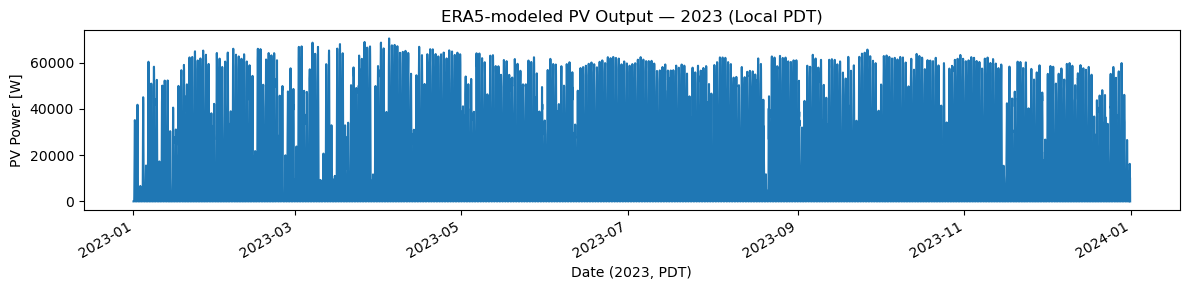

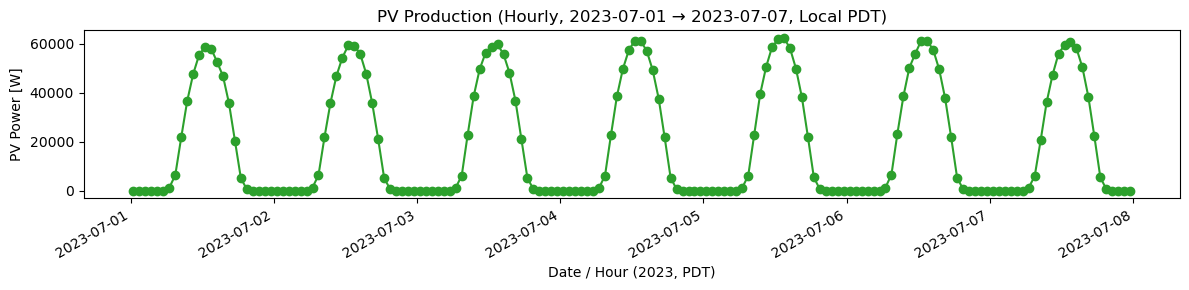

In [48]:
# ─── Cell 3 (final, fully corrected): Load/clean/shift PV data, trim to 2023, and plot a sample week ─────────────────

import pandas as pd
import matplotlib.pyplot as plt

power_path = (
    "C:/Users/jcrem/Desktop/ECE 228/Term Project/Data/OG/"
    "Timeseries_32.881_-117.233_E5_84kWp_crystSi_14_31deg_3deg_2022_2023.csv"
)

# 1) Read only the first 7 columns (time + 6 data columns), skipping the 10 header lines
df_power = pd.read_csv(
    power_path,
    skiprows=10,
    usecols=range(7),
    header=0
)

# 2) Force the correct column names
df_power.columns = ["time", "P", "G(i)", "H_sun", "T2m", "WS10m", "Int"]

# 3) Drop any “footer” rows whose 'time' does not match the pattern YYYYMMDD:HHMM
mask = df_power["time"].str.match(r"^\d{8}:\d{4}$")
df_power = df_power.loc[mask].copy()

# 4) Parse 'time' exactly as UTC, then set it as the index
df_power["time"] = pd.to_datetime(df_power["time"], format="%Y%m%d:%H%M", utc=True)
df_power.set_index("time", inplace=True)

# 5) Convert the index from UTC → America/Los_Angeles, then drop the timezone tag
df_power.index = df_power.index.tz_convert("America/Los_Angeles")
df_power.index = df_power.index.tz_localize(None)

# 6) Convert all data columns (“P”, “G(i)”, “H_sun”, “T2m”, “WS10m”, “Int”) to float64
for col in ["P", "G(i)", "H_sun", "T2m", "WS10m", "Int"]:
    df_power[col] = pd.to_numeric(df_power[col], errors="coerce")

# 7) Drop any rows where 'P' failed to convert (NaN) so that “P > 0” comparisons work
df_power = df_power.dropna(subset=["P"])

# 8) Sanity‐check: print the first few nonzero‐PV timestamps (now correctly in local PDT)
print("First few nonzero PV readings (local PDT after shift):")
print(df_power[df_power["P"] > 0].head(10))
print()

# 9) Trim to 2023 in local time
df_power = df_power[df_power.index.year == 2023]
print(f"Rows after subsetting to 2023 only: {len(df_power)}")
print("First/Last timestamps in 2023 (local PDT):", df_power.index.min(), "→", df_power.index.max())
print()

# 10) Full‐year plot of 2023 PV (verify sunrise/sunset alignment)
plt.figure(figsize=(12, 3))
df_power["P"].plot(
    title="ERA5‐modeled PV Output — 2023 (Local PDT)",
    color="tab:blue"
)
plt.ylabel("PV Power [W]")
plt.xlabel("Date (2023, PDT)")
plt.tight_layout()
plt.show()

# 11) Sample‐Week Plot: pick any 7-day window (e.g. 2023-07-01 → 2023-07-07)
sample_start = "2023-07-01"
sample_end   = "2023-07-07"
df_week = df_power.loc[sample_start:sample_end]

plt.figure(figsize=(12, 3))
df_week["P"].plot(
    title="PV Production (Hourly, 2023-07-01 → 2023-07-07, Local PDT)",
    marker="o",
    linestyle="-",
    color="tab:green"
)
plt.ylabel("PV Power [W]")
plt.xlabel("Date / Hour (2023, PDT)")
plt.tight_layout()
plt.show()


In [49]:
# ─── Cell 4 (using Open-Meteo to pull ERA5 2023) ─────────────────────────

import requests
import pandas as pd
import numpy as np

loc_tz      = "America/Los_Angeles"
today_pdt   = pd.Timestamp.now(tz=loc_tz).normalize()
start_2023  = "2023-01-01"
end_2023    = "2023-12-31"

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude":   32.881,
    "longitude": -117.233,
    "start_date": start_2023,
    "end_date":   end_2023,
    "hourly": ",".join([
        "temperature_2m", "relativehumidity_2m", 
        "windspeed_10m", "winddirection_10m", 
        "pressure_msl", "shortwave_radiation",
        "direct_radiation", "diffuse_radiation",
    ]),
    "timezone": loc_tz,
}

r = requests.get(url, params=params)
r.raise_for_status()
hourly = r.json()["hourly"]

df_met = pd.DataFrame(hourly)
df_met["time"] = pd.to_datetime(df_met["time"])
df_met.set_index("time", inplace=True)
df_met.index = df_met.index + pd.Timedelta(minutes=30)

df_met = df_met.rename(columns={
    "temperature_2m":      "T2m",
    "relativehumidity_2m": "RH",
    "shortwave_radiation": "G(i)",
    "direct_radiation":    "Gb(n)",
    "diffuse_radiation":   "Gd(h)",
    "windspeed_10m":       "WS10m",
    "winddirection_10m":   "WD10m",
    "pressure_msl":        "SP",
})
df_met["hour"]   = df_met.index.hour
df_met["doy"]    = df_met.index.dayofyear
df_met["hour_sin"] = np.sin(2*np.pi * df_met["hour"]/24)
df_met["hour_cos"] = np.cos(2*np.pi * df_met["hour"]/24)
df_met["day_sin"]  = np.sin(2*np.pi * df_met["doy"]/365)
df_met["day_cos"]  = np.cos(2*np.pi * df_met["doy"]/365)

print("Open-Meteo ERA5 2023 shape:", df_met.shape)
print(df_met.index.min(), "→", df_met.index.max())
display(df_met.head(), df_met.tail())


Open-Meteo ERA5 2023 shape: (8760, 14)
2023-01-01 00:30:00 → 2023-12-31 23:30:00


,T2m,RH,WS10m,WD10m,SP,G(i),Gb(n),Gd(h),hour,doy,hour_sin,hour_cos,day_sin,day_cos
time,,,,,,,,,,,,,,
2023-01-01 00:30:00,13.7,93,34.4,164,1010.3,0.0,0.0,0.0,0,1,0.000000,1.000000,0.017213,0.999852
2023-01-01 01:30:00,13.3,97,36.6,170,1008.8,0.0,0.0,0.0,1,1,0.258819,0.965926,0.017213,0.999852
2023-01-01 02:30:00,13.7,97,38.3,185,1008.1,0.0,0.0,0.0,2,1,0.500000,0.866025,0.017213,0.999852
2023-01-01 03:30:00,14.1,97,39.8,201,1007.6,0.0,0.0,0.0,3,1,0.707107,0.707107,0.017213,0.999852
2023-01-01 04:30:00,13.1,91,30.0,264,1008.0,0.0,0.0,0.0,4,1,0.866025,0.500000,0.017213,0.999852


,T2m,RH,WS10m,WD10m,SP,G(i),Gb(n),Gd(h),hour,doy,hour_sin,hour_cos,day_sin,day_cos
time,,,,,,,,,,,,,,
2023-12-31 19:30:00,12.5,90,5.9,322,1017.7,0.0,0.0,0.0,19,365,-0.965926,0.258819,6.432491e-16,1.0
2023-12-31 20:30:00,12.2,90,5.1,4,1018.1,0.0,0.0,0.0,20,365,-0.866025,0.500000,6.432491e-16,1.0
2023-12-31 21:30:00,11.7,92,3.8,41,1018.5,0.0,0.0,0.0,21,365,-0.707107,0.707107,6.432491e-16,1.0
2023-12-31 22:30:00,11.5,92,6.2,69,1018.6,0.0,0.0,0.0,22,365,-0.500000,0.866025,6.432491e-16,1.0
2023-12-31 23:30:00,11.1,94,8.3,85,1018.5,0.0,0.0,0.0,23,365,-0.258819,0.965926,6.432491e-16,1.0


In [50]:
# ─── Cell 5: Merge PV output (df_power) & meteorology (df_met) ────────────────

# 5.1) Drop any meteorological columns in df_power that would collide with df_met:
#      (e.g. "T2m", "WS10m", or "G(i)" if df_met also has a "G(i)" field.)
df_power = df_power.drop(columns=["T2m", "WS10m", "G(i)"], errors="ignore")

# 5.2) Now join on the datetime index (inner‐join ensures we keep only hours present in both):
df = df_power.join(df_met, how="inner")

print("Merged DataFrame shape:", df.shape)
print("Total missing values after merge:", df.isna().sum().sum())
display(df.head(), df.tail())


Merged DataFrame shape: (8752, 17)
Total missing values after merge: 0


,P,H_sun,Int,T2m,RH,WS10m,WD10m,SP,G(i),Gb(n),Gd(h),hour,doy,hour_sin,hour_cos,day_sin,day_cos
time,,,,,,,,,,,,,,,,,
2023-01-01 00:30:00,0.0,0.0,0.0,13.7,93,34.4,164,1010.3,0.0,0.0,0.0,0,1,0.000000,1.000000,0.017213,0.999852
2023-01-01 01:30:00,0.0,0.0,0.0,13.3,97,36.6,170,1008.8,0.0,0.0,0.0,1,1,0.258819,0.965926,0.017213,0.999852
2023-01-01 02:30:00,0.0,0.0,0.0,13.7,97,38.3,185,1008.1,0.0,0.0,0.0,2,1,0.500000,0.866025,0.017213,0.999852
2023-01-01 03:30:00,0.0,0.0,0.0,14.1,97,39.8,201,1007.6,0.0,0.0,0.0,3,1,0.707107,0.707107,0.017213,0.999852
2023-01-01 04:30:00,0.0,0.0,0.0,13.1,91,30.0,264,1008.0,0.0,0.0,0.0,4,1,0.866025,0.500000,0.017213,0.999852


,P,H_sun,Int,T2m,RH,WS10m,WD10m,SP,G(i),Gb(n),Gd(h),hour,doy,hour_sin,hour_cos,day_sin,day_cos
time,,,,,,,,,,,,,,,,,
2023-12-31 11:30:00,16227.96,33.77,0.0,13.6,89,7.9,180,1022.0,112.0,6.0,106.0,11,365,2.588190e-01,-0.965926,6.432491e-16,1.0
2023-12-31 12:30:00,15498.84,33.28,0.0,13.9,89,4.8,193,1021.7,111.0,4.0,107.0,12,365,1.224647e-16,-1.000000,6.432491e-16,1.0
2023-12-31 13:30:00,10060.68,29.31,0.0,14.6,86,5.8,266,1021.0,228.0,26.0,202.0,13,365,-2.588190e-01,-0.965926,6.432491e-16,1.0
2023-12-31 14:30:00,10211.04,22.49,0.0,14.9,81,8.0,275,1019.9,271.0,62.0,209.0,14,365,-5.000000e-01,-0.866025,6.432491e-16,1.0
2023-12-31 15:30:00,0.00,0.00,0.0,15.1,78,4.3,294,1019.1,270.0,55.0,215.0,15,365,-7.071068e-01,-0.707107,6.432491e-16,1.0


Feature matrix X shape: (8752, 12)
Target vector y shape:    (8752,)


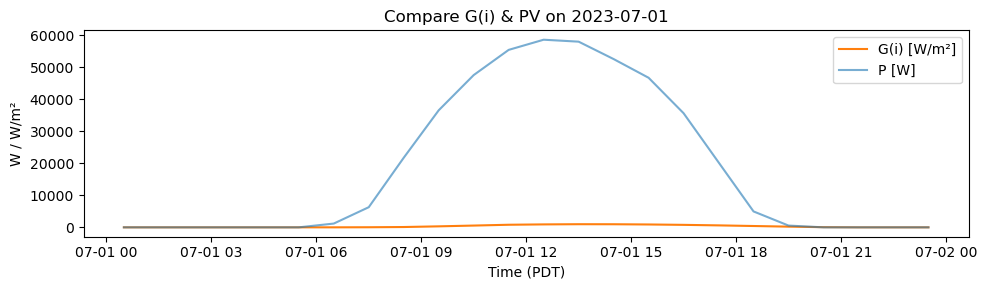

In [51]:
# ─── Cell 6: Define features & target, plus a quick 1‐day sanity‐plot ─────────────────

import numpy as np

# 6.1) Target: PV power in W
y = df["P"].values     # shape (8760,)

# 6.2) Features: whichever met vars you want. 
#      Double‐check column names exactly match df.columns
feature_cols = ["G(i)", "Gb(n)", "Gd(h)", "T2m", "RH", "WS10m", "WD10m", "SP",
                "hour_sin", "hour_cos", "day_sin", "day_cos"]
X = df[feature_cols].values   # shape (8760, 12)

print("Feature matrix X shape:", X.shape)
print("Target vector y shape:   ", y.shape)

# 6.3) Quick‐plot: PV vs. G(i) on a single summer day
single_day = "2023-07-01"
plt.figure(figsize=(10, 3))
plt.plot(df.loc[single_day, "G(i)"], label="G(i) [W/m²]", color="tab:orange")
plt.plot(df.loc[single_day, "P"],   label="P [W]",           color="tab:blue", alpha=0.6)
plt.ylabel("W / W/m²")
plt.xlabel("Time (PDT)")
plt.title("Compare G(i) & PV on 2023-07-01")
plt.legend()
plt.tight_layout()
plt.show()




In [52]:
# ─── Cell 7: Scale features & target (MinMaxScaler) ─────────────────────────────

from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)               # shape (8760, 12)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)) # shape (8760, 1)

print("Scaled X shape:", X_scaled.shape, " min/max:", X_scaled.min(), "/", X_scaled.max())
print("Scaled y shape:", y_scaled.shape, " min/max:", y_scaled.min(), "/", y_scaled.max())


Scaled X shape: (8752, 12)  min/max: 0.0 / 1.0
Scaled y shape: (8752, 1)  min/max: 0.0 / 1.0


In [53]:
# ─── Cell 8: Create supervised sequences (lookback=24, horizon=24) ──────────────

import numpy as np

def make_sequences(X, y, lookback=24, horizon=24):
    """
    Turn X (T×n_feats) and y (T×1) into:
      X_seq: (N, lookback, n_feats)
      y_seq: (N, horizon)
    where N = T - lookback - horizon + 1
    """
    T, n_feats = X.shape[0], X.shape[1]
    N = T - lookback - horizon + 1
    X_seq = np.zeros((N, lookback, n_feats), dtype=np.float32)
    y_seq = np.zeros((N, horizon),      dtype=np.float32)
    for i in range(N):
        X_seq[i] = X[i : i + lookback]
        y_seq[i] = y[i + lookback : i + lookback + horizon].ravel()
    return X_seq, y_seq

lookback, horizon = 24, 24
X_seq, y_seq = make_sequences(X_scaled, y_scaled, lookback, horizon)

print("X_seq shape:", X_seq.shape)   # ≈ (8713, 24, 12)
print("y_seq shape:", y_seq.shape)   # ≈ (8713, 24)


X_seq shape: (8705, 24, 12)
y_seq shape: (8705, 24)


In [54]:
# ─── Cell 9: Train/validation split with rolling CV ───────────────────────────
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# ─── Ensure these are defined from X_seq/y_seq ─────────────────────────────────
lookback = X_seq.shape[1]  # e.g. 24
n_feats  = X_seq.shape[2]  # e.g. 12
horizon  = y_seq.shape[1]  # e.g. 24

# ─── Add the necessary Keras imports ─────────────────────────────────────────
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

fold = 0
all_history = []
all_metrics = []

for train_idx, val_idx in tscv.split(X_seq):
    fold += 1
    print(f"\n\n===== Fold {fold}/{n_splits} =====")
    
    # 2) Extract train/val for this fold
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]
    
    # 3) Re‑instantiate your model from scratch
    model = Sequential([
        Input(shape=(lookback, n_feats)),
        LSTM(50, return_sequences=False),
        Dense(horizon, activation="softplus")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    # 4) Train on this fold
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=3,
                restore_best_weights=True
            )
        ],
        verbose=1
    )
    
    # 5) Evaluate on this fold’s validation set
    metrics = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold} Val Loss: {metrics[0]:.4f}, Val MAE: {metrics[1]:.4f}")
    
    all_history.append(history)
    all_metrics.append(metrics)

# After the loop:
avg_metrics = np.mean(all_metrics, axis=0)
print(f"\nAverage across {n_splits} folds → Val Loss: {avg_metrics[0]:.4f}, Val MAE: {avg_metrics[1]:.4f}")

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
assert X_train.shape[0] + X_val.shape[0] == X_seq.shape[0], "Train/val sizing mismatch"




===== Fold 1/5 =====
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2503 - mae: 0.4458 - val_loss: 0.1023 - val_mae: 0.2675
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0831 - mae: 0.2432 - val_loss: 0.0807 - val_mae: 0.2393
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0616 - mae: 0.2124 - val_loss: 0.0520 - val_mae: 0.1897
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0390 - mae: 0.1661 - val_loss: 0.0351 - val_mae: 0.1501
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0263 - mae: 0.1305 - val_loss: 0.0280 - val_mae: 0.1267
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0221 - mae: 0.1130 - val_loss: 0.0253 - val_mae: 0.1158
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0199 - mae: 0.1041 - val_loss: 0.0261 - val_mae: 0.1143
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0189 - mae: 0.0989 - val_loss: 0.0289 - val_mae: 0.1171
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [55]:
# ─── Cell 10: Quantile LSTM + Hyperparameter Search (Fixed) ────────────────────

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Reshape
import keras_tuner as kt

# 10.1) Cast everything to float32 (just to be 100% safe)
X_train = X_train.astype("float32")
X_val   = X_val.astype("float32")
y_train = y_train.astype("float32")
y_val   = y_val.astype("float32")

# 1) Define which quantiles we want to predict:
quantiles = [0.25, 0.50, 0.75]
num_q = len(quantiles)

# 2) Custom quantile‐loss factory:
def quantile_loss(q):
    def _loss(y_true, y_pred):
        # y_true: (batch, horizon)
        # y_pred: (batch, horizon) for this specific quantile
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))
    return _loss

# 3) Combined “sum of quantile” loss:
def multi_quantile_loss(y_true, y_pred):
    # y_pred: (batch, horizon, num_q)
    losses = []
    for i, q in enumerate(quantiles):
        pred_i = y_pred[:, :, i]   # shape (batch, horizon)
        losses.append(quantile_loss(q)(y_true, pred_i))
    return tf.add_n(losses)

# 4) Build_model function for Keras‑Tuner:
def build_quantile_model(hp):
    """
    hp: HyperParameters object provided by Keras‑Tuner
    We will tune:
      - number of LSTM layers (1 or 2)
      - units per LSTM layer (32, 64, 96, 128)
      - dropout rate (0.0, 0.2, 0.5)
      - learning rate (1e‑2, 1e‑3, 1e‑4)
    """
    model = Sequential()
    model.add(Input(shape=(lookback, n_feats)))  # e.g. (24, 12)

    # Tune how many LSTM layers:
    num_lstm_layers = hp.Int("num_lstm_layers", min_value=1, max_value=2, step=1)
    for i in range(num_lstm_layers):
        units = hp.Int(f"units_lstm_{i}", min_value=32, max_value=128, step=32)
        return_seq = (i < num_lstm_layers - 1)
        model.add(LSTM(units, return_sequences=return_seq))
    
    # Tune dropout rate after last LSTM:
    dropout_rate = hp.Choice("dropout_rate", values=[0.0, 0.2, 0.5])
    if dropout_rate > 0.0:
        model.add(Dropout(rate=dropout_rate))
    
    # Final Dense to output (horizon * num_q) values, then reshape to (horizon, num_q)
    model.add(Dense(horizon * num_q, activation="linear"))
    model.add(Reshape((horizon, num_q)))  # (batch, 24, 3)

    # Tune learning rate for Adam:
    lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=multi_quantile_loss,
        metrics=[]  # ← remove MeanAbsoluteError() to avoid shape mismatch
    )
    return model

# 5) Instantiate a tuner (RandomSearch example):
tuner = kt.RandomSearch(
    build_quantile_model,
    objective="val_loss",                # ← optimize the validation loss directly
    max_trials=10,                        # Try up to 10 different hyperparameter sets
    executions_per_trial=1,               # Single execution per trial
    directory="kt_dir",                   # Folder to store tuning logs
    project_name="pv_quantile_tuning"
)

# 6) Run the hyperparameter search:
tuner.search(
    X_train, y_train,
    epochs=10,                             # Fewer epochs per trial for speed
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
    ]
)

# 7) Retrieve the best model found by Keras‑Tuner:
best_model = tuner.get_best_models(num_models=1)[0]

# 8) Set the memory model to best_model
model = best_model

# 9) (Optional) See which hyperparameters were chosen:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"  • num_lstm_layers = {best_hps.get('num_lstm_layers')}")
for i in range(best_hps.get("num_lstm_layers")):
    print(f"  • units_lstm_{i} = {best_hps.get(f'units_lstm_{i}')}")
print(f"  • dropout_rate    = {best_hps.get('dropout_rate')}")
print(f"  • learning_rate   = {best_hps.get('learning_rate')}")



Reloading Tuner from kt_dir\pv_quantile_tuning\tuner0.json
Best hyperparameters:
  • num_lstm_layers = 2
  • units_lstm_0 = 128
  • units_lstm_1 = 64
  • dropout_rate    = 0.0
  • learning_rate   = 0.01


C:\Users\jcrem\anaconda3\envs\ml_gpu\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [56]:
# ─── Cell 11: Train the LSTM ───────────────────────────────────────────────────

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

print("Training completed. History keys:", list(history.history.keys()))


Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0671 - val_loss: 0.0773
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0550 - val_loss: 0.0775
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0521 - val_loss: 0.0763
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0511 - val_loss: 0.0812
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0483 - val_loss: 0.0852
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0468 - val_loss: 0.0900
Training completed. History keys: ['loss', 'val_loss']


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  


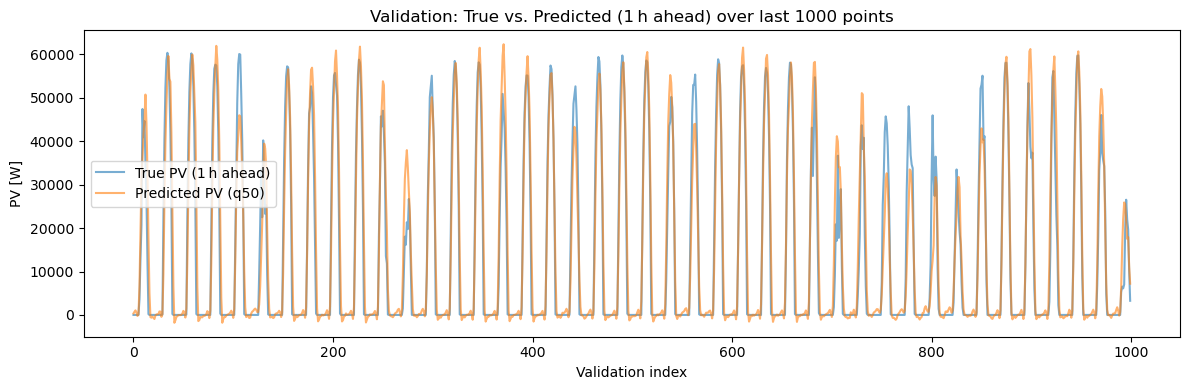

Validation 1 h ahead (median) → RMSE: 6418.3 W, MAE: 3642.6 W
Validation all 24 h (flattened) → RMSE: 7421.4 W, MAE: 4039.8 W


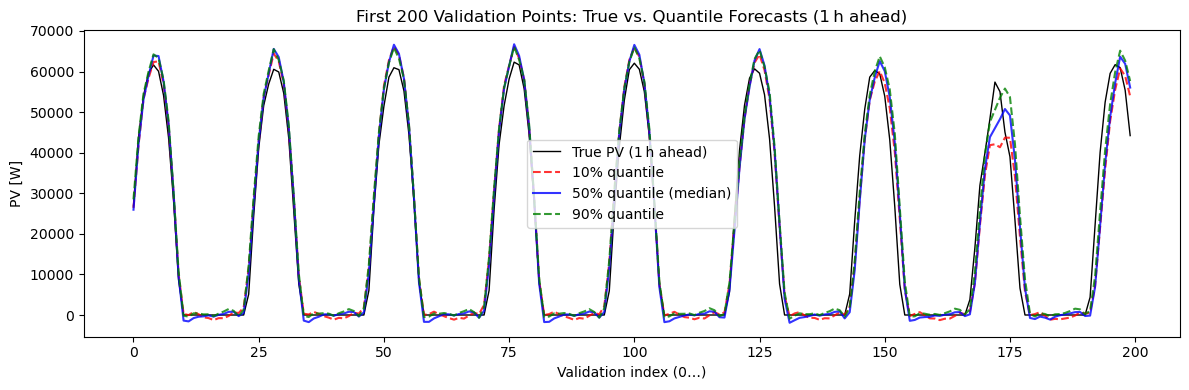

In [57]:
# ─── Cell 12: Evaluate & Invert Scaling (Fix for 3‐D Quantile Output) ─────────

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

# (a) Predict on the entire validation set
y_val_pred_scaled = model.predict(X_val)    # shape == (N_val, 24, 3)

# --- STEP 1: Extract the median (0.50) quantile as a point forecast ---------------
#    We assume quantiles = [0.10, 0.50, 0.90], so index 1 => 50% quantile
y_val_pred_q50 = y_val_pred_scaled[:, :, 1]  # shape == (N_val, 24)

# (b) Inverse‐scale that 2D array back to Watts
y_val_pred_q50_unscaled = scaler_y.inverse_transform(y_val_pred_q50)  
#    shape == (N_val, 24)

# (c) Inverse‐scale the true (validation) target y_val
#    (Recall y_val was the scaled version of the true PV)
y_val_true_unscaled = scaler_y.inverse_transform(y_val)  
#    shape == (N_val, 24)

# (d) Now pull out the 1 h ahead component (column 0)
y_true_1h = y_val_true_unscaled[:, 0]    # shape (N_val,)
y_pred_1h = y_val_pred_q50_unscaled[:, 0]  # shape (N_val,)

# (e) Quick plot: last 1000 points of 1 h ahead
plt.figure(figsize=(12, 4))
plt.plot(y_true_1h[-1000:], label="True PV (1 h ahead)", alpha=0.6)
plt.plot(y_pred_1h[-1000:], label="Predicted PV (q50)", alpha=0.6)
plt.legend()
plt.title("Validation: True vs. Predicted (1 h ahead) over last 1000 points")
plt.ylabel("PV [W]")
plt.xlabel("Validation index")
plt.tight_layout()
plt.show()

# (f) Compute 1 h‐ahead RMSE & MAE using the median forecast
rmse_1h = sqrt(mean_squared_error(y_true_1h, y_pred_1h))
mae_1h  = mean_absolute_error(y_true_1h, y_pred_1h)
print(f"Validation 1 h ahead (median) → RMSE: {rmse_1h:.1f} W, MAE: {mae_1h:.1f} W")


# (g) Compute “flattened” 24 h–ahead metrics over the entire validation set
#     (i.e. compare all 24*N_val predictions to all 24*N_val true values)
y_true_flat = y_val_true_unscaled.ravel()       # length = N_val * 24
y_pred_flat = y_val_pred_q50_unscaled.ravel()   # same length

rmse_24h = sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mae_24h  = mean_absolute_error(y_true_flat, y_pred_flat)
print(f"Validation all 24 h (flattened) → RMSE: {rmse_24h:.1f} W, MAE: {mae_24h:.1f} W")


# --- OPTIONAL: If you also want to extract / plot the 10% and 90% bands ------------
# (h) Inverse‐scale the entire 3D array, column by column:
y_val_pred_q10_unscaled = scaler_y.inverse_transform(y_val_pred_scaled[:, :, 0]) 
y_val_pred_q90_unscaled = scaler_y.inverse_transform(y_val_pred_scaled[:, :, 2])

# Now you have y_val_pred_q10_unscaled, y_val_pred_q50_unscaled, y_val_pred_q90_unscaled,
# all with shape (N_val, 24). You can plot them or compute coverage, etc.
# For example, to plot the 1 h ahead true vs all three quantiles for the first 200 points:
plt.figure(figsize=(12, 4))
plt.plot(y_true_1h[:200], color='k', label="True PV (1 h ahead)", linewidth=1)
plt.plot(y_val_pred_q10_unscaled[:, 0][:200], 'r--', label="10% quantile", alpha=0.8)
plt.plot(y_val_pred_q50_unscaled[:, 0][:200], 'b-', label="50% quantile (median)", alpha=0.8)
plt.plot(y_val_pred_q90_unscaled[:, 0][:200], 'g--', label="90% quantile", alpha=0.8)
plt.legend()
plt.title("First 200 Validation Points: True vs. Quantile Forecasts (1 h ahead)")
plt.ylabel("PV [W]")
plt.xlabel("Validation index (0…)")
plt.tight_layout()
plt.show()


In [58]:
# ─── Cell 13: Persistence Baseline (1 h ahead) ───────────────────────────────────

from sklearn.metrics import mean_squared_error
from math import sqrt

# Align shapes: drop the first horizon row so that we can do PV(t) → PV(t+1)
y_true_1h = y_val[1:, 0]        # (1742,) real 1h ahead target
y_pers_1h = y_val[:-1, 0]       # (1742,) persistence = PV(t)

# Invert‐scale to get back to W
y_true_1h = scaler_y.inverse_transform(y_true_1h.reshape(-1,1)).ravel()
y_pers_1h = scaler_y.inverse_transform(y_pers_1h.reshape(-1,1)).ravel()

rmse_pers = sqrt(mean_squared_error(y_true_1h, y_pers_1h))
print(f"Persistence RMSE (1-h ahead): {rmse_pers:.1f} W")


Persistence RMSE (1-h ahead): 8114.7 W


Pulling forecast for local date: 2025-06-01
Forecast rows: 24 2025-06-01 00:30:00 → 2025-06-01 23:30:00
No real obs for 2025-05-31; backfilling from forecast first 24 rows
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Hour-by-hour G(i) and predicted PV:
00:30 → G(i)=  0.0 W/m², PV_pred=    0.0 W
01:30 → G(i)=  0.0 W/m², PV_pred=    0.0 W
02:30 → G(i)=  0.0 W/m², PV_pred=    0.0 W
03:30 → G(i)=  0.0 W/m², PV_pred=    0.0 W
04:30 → G(i)=  0.0 W/m², PV_pred=    0.0 W
05:30 → G(i)=  0.0 W/m², PV_pred=    0.0 W
06:30 → G(i)=  0.0 W/m², PV_pred=    0.0 W
07:30 → G(i)= 65.0 W/m², PV_pred= 5990.8 W
08:30 → G(i)=262.8 W/m², PV_pred=17039.7 W
09:30 → G(i)=473.2 W/m², PV_pred=30027.1 W
10:30 → G(i)=592.5 W/m², PV_pred=41880.9 W
11:30 → G(i)=700.0 W/m², PV_pred=47212.3 W
12:30 → G(i)=669.0 W/m², PV_pred=51104.6 W
13:30 → G(i)=859.0 W/m², PV_pred=50272.4 W
14:30 → G(i)=920.0 W/m², PV_pred=47745.6 W
15:30 → G(i)=228.0 W/m², PV_pred=38897.6 W
16:30 → G(i)=770.0 W/m², PV_pred=26545.4 W
17:30 → G(i)=476.0 W/m

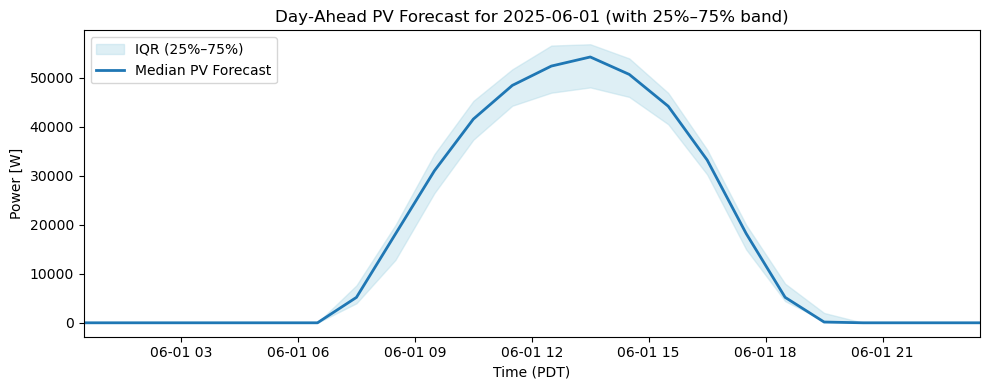

'\n# Suppose you load actual tomorrow’s PV into `df_power` once it arrives:\nif day_str in df_power.index.normalize().strftime("%Y-%m-%d").values:\n    df_actual_tomorrow = df_power.loc[day_str]  # 24 hourly points\n    y_true_tomorrow   = df_actual_tomorrow["P"].values  # or whatever column holds PV\n\n    plt.figure(figsize=(10, 4))\n    plt.fill_between(\n        df_fore.index, y_f_q25, y_f_q75,\n        color="lightblue", alpha=0.4, label="IQR (25%–75%)"\n    )\n    plt.plot(\n        df_fore.index, y_f_q50,\n        color="tab:blue", linewidth=2, label="Median Forecast"\n    )\n    plt.plot(\n        df_fore.index, y_true_tomorrow,\n        color="k", linestyle="--", linewidth=1.5, label="Actual PV"\n    )\n    plt.title(f"Forecast vs Actual on {day_str} (25%–75% Band)")\n    plt.ylabel("Power [W]")\n    plt.xlabel("Time (PDT)")\n    plt.xlim(xmin, xmax)\n    plt.legend(loc="upper left")\n    plt.tight_layout()\n    plt.show()\n'

In [59]:
# ─── Cell 14: True 24-h Day-Ahead Inference ─────────────────────────────

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

# 14.1) Determine “tomorrow” in local PDT
loc_tz    = "America/Los_Angeles"
today_pdt = pd.Timestamp.now(tz=loc_tz).normalize()
tomorrow  = today_pdt + pd.Timedelta(days=1)
day_str   = tomorrow.strftime("%Y-%m-%d")
print("Pulling forecast for local date:", day_str)

# 14.2) Fetch exactly that 24-hour window from Open-Meteo
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude":   32.881,
    "longitude": -117.233,
    "hourly": ",".join([
        "temperature_2m", "relativehumidity_2m",
        "windspeed_10m", "winddirection_10m",
        "pressure_msl", "shortwave_radiation",
        "direct_radiation", "diffuse_radiation",
    ]),
    "start_date": day_str,
    "end_date":   day_str,
    "timezone":   loc_tz,
}
r = requests.get(url, params=params)
r.raise_for_status()
df_fore = pd.DataFrame(r.json()["hourly"])

# 14.3) Parse “time” as datetime, set it as index, then shift each to :30 past the hour
df_fore["time"] = pd.to_datetime(df_fore["time"])
df_fore.set_index("time", inplace=True)
df_fore.index = df_fore.index + pd.Timedelta(minutes=30)

# 14.4) Rename columns to match feature_cols and build calendar encodings
df_fore = df_fore.rename(columns={
    "temperature_2m":      "T2m",
    "relativehumidity_2m": "RH",
    "shortwave_radiation": "G(i)",
    "direct_radiation":    "Gb(n)",
    "diffuse_radiation":   "Gd(h)",
    "windspeed_10m":       "WS10m",
    "winddirection_10m":   "WD10m",
    "pressure_msl":        "SP",
})

df_fore["hour"]   = df_fore.index.hour
df_fore["doy"]    = df_fore.index.dayofyear
df_fore["hour_sin"] = np.sin(2 * np.pi * df_fore["hour"] / 24)
df_fore["hour_cos"] = np.cos(2 * np.pi * df_fore["hour"] / 24)
df_fore["day_sin"]  = np.sin(2 * np.pi * df_fore["doy"] / 365)
df_fore["day_cos"]  = np.cos(2 * np.pi * df_fore["doy"] / 365)

# 14.5) Sanity-check: exactly 24 rows (00:30 → 23:30 PDT)
print("Forecast rows:", len(df_fore), df_fore.index.min(), "→", df_fore.index.max())

# 14.6) Build the 24×n_features matrix and scale
#       (feature_cols must be exactly the same 12 names you used during training)
X_nwp_24       = df_fore[feature_cols].values   # shape (24, 12)
X_nwp_24_scaled = scaler_X.transform(X_nwp_24)  # shape (24, 12)

obs_date_str = today_pdt.strftime("%Y-%m-%d")  # e.g. "2023-05-30"
dates_in_df   = df_power.index.normalize().strftime("%Y-%m-%d").unique()

if obs_date_str in dates_in_df:
    # Case A: We have today’s date present in df_power
    df_obs_day = df_power.loc[obs_date_str]  # 24 rows: 00:30→23:30 PDT
    print("Using real observations for", obs_date_str,
          "; rows:", len(df_obs_day),
          df_obs_day.index.min(), "→", df_obs_day.index.max())
    X_obs_24 = df_obs_day[feature_cols].values       # shape (24, 12)
else:
    # Case B: If there are no real obs for that date, backfill from df_fore’s first 24 rows
    print(f"No real obs for {obs_date_str}; backfilling from forecast first 24 rows")
    X_obs_24 = df_fore[feature_cols].iloc[:24].values  # shape (24, 12)

X_obs_24_scaled = scaler_X.transform(X_obs_24)  # shape (24, 12)

# 14.7) Build the single (1, 24, 12) input for the LSTM (we trained on 24→24)
X_input = X_obs_24_scaled[np.newaxis, :, :]  # shape (1, 24, 12)

# 14.8a) Model outputs shape (1, 24, 3) for [q25, q50, q75]
y_f_scaled_all = model.predict(X_input)  
#    shape == (1, 24, 3)

# 14.8b) Extract each quantile slice:
y_f_scaled_q25 = y_f_scaled_all[:, :, 0]   # shape (1, 24)
y_f_scaled_q50 = y_f_scaled_all[:, :, 1]   # shape (1, 24)
y_f_scaled_q75 = y_f_scaled_all[:, :, 2]   # shape (1, 24)

# 14.8c) Inverse–scale each 2D array:
y_f_q25 = scaler_y.inverse_transform(y_f_scaled_q25).ravel()  # shape (24,)
y_f_q50 = scaler_y.inverse_transform(y_f_scaled_q50).ravel()  # shape (24,)
y_f_q75 = scaler_y.inverse_transform(y_f_scaled_q75).ravel()  # shape (24,)

# 14.9) Low‑irradiance fallback: if 0 < G(i) < 50, override all three quantiles
G_vals     = df_fore["G(i)"].values   # shape (24,)
systemslop = 84_000 / 1000.0          # 84 W per 1 W/m²
low_thresh = 50

for i, gh in enumerate(G_vals):
    if 0 < gh < low_thresh:
        y_f_q25[i] = systemslop * gh
        y_f_q50[i] = systemslop * gh
        y_f_q75[i] = systemslop * gh

# Zero‑clip whenever G(i) == 0
mask_zero = (G_vals == 0)
y_f_q25[mask_zero] = 0.0
y_f_q50[mask_zero] = 0.0
y_f_q75[mask_zero] = 0.0

# 14.10) Optional diagnostic print: hour-by-hour check
print("\nHour-by-hour G(i) and predicted PV:")
for timestamp, gh_val, pv_val in zip(df_fore.index, G_vals, y_f):
    print(f"{timestamp.strftime('%H:%M')} → G(i)={gh_val:5.1f} W/m², PV_pred={pv_val:7.1f} W")

# 14.11) Plot 24‑h Quartile Band ──────────────────────────────────────────

import matplotlib.pyplot as plt

xmin, xmax = df_fore.index.min(), df_fore.index.max()

plt.figure(figsize=(10, 4))
# Fill the area between q25 and q75
plt.fill_between(
    df_fore.index,
    y_f_q25,
    y_f_q75,
    color="lightblue",
    alpha=0.4,
    label="IQR (25%–75%)"
)
# Plot the median line on top
plt.plot(
    df_fore.index,
    y_f_q50,
    color="tab:blue",
    linewidth=2,
    label="Median PV Forecast"
)
plt.title(f"Day‑Ahead PV Forecast for {day_str} (with 25%–75% band)")
plt.ylabel("Power [W]")
plt.xlabel("Time (PDT)")
plt.xlim(xmin, xmax)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


# Suppose you load actual tomorrow’s PV into `df_power` once it arrives:
#if day_str in df_power.index.normalize().strftime("%Y-%m-%d").values:
#    df_actual_tomorrow = df_power.loc[day_str]  # 24 hourly points
#    y_true_tomorrow   = df_actual_tomorrow["P"].values  # or whatever column holds PV
#
#    plt.figure(figsize=(10, 4))
#    plt.fill_between(
#        df_fore.index, y_f_q25, y_f_q75,
#        color="lightblue", alpha=0.4, label="IQR (25%–75%)"
#    )
#    plt.plot(
#        df_fore.index, y_f_q50,
#        color="tab:blue", linewidth=2, label="Median Forecast"
#    )
#    plt.plot(
#        df_fore.index, y_true_tomorrow,
#        color="k", linestyle="--", linewidth=1.5, label="Actual PV"
#    )
#    plt.title(f"Forecast vs Actual on {day_str} (25%–75% Band)")
#    plt.ylabel("Power [W]")
#    plt.xlabel("Time (PDT)")
#    plt.xlim(xmin, xmax)
#    plt.legend(loc="upper left")
#    plt.tight_layout()
#    plt.show()


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


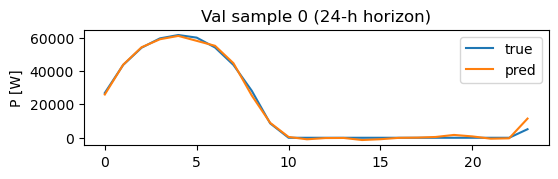

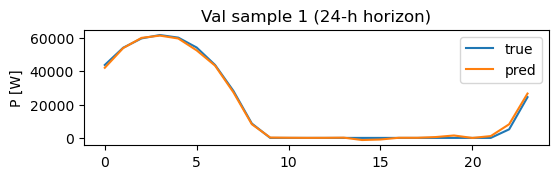

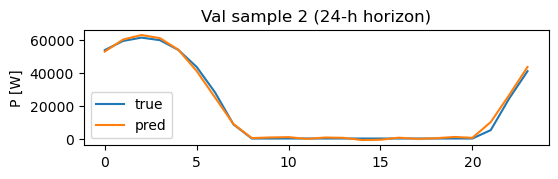

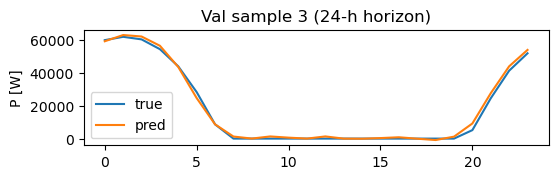

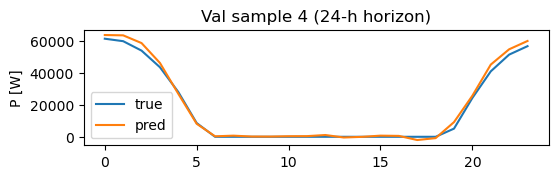

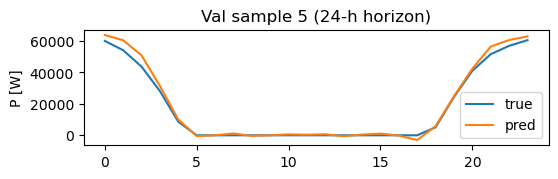

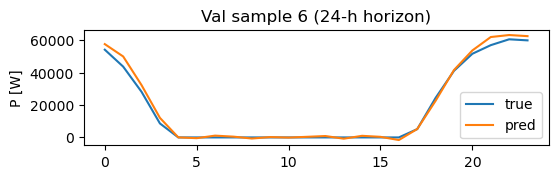

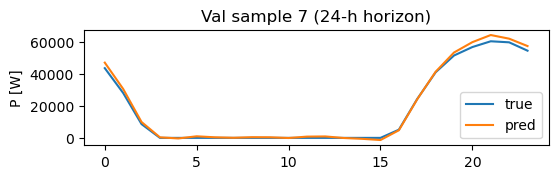

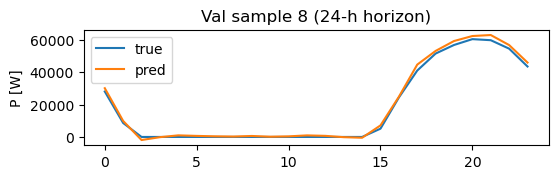

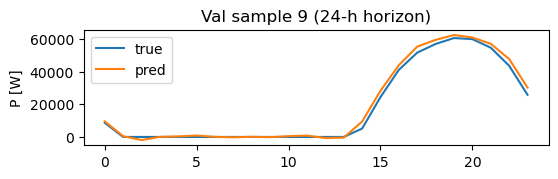

Validation RMSE (24‑h): 7421.3691459191


In [61]:
# Cell 15 (updated): Diagnostic: full‐val 24 h prediction vs. truth

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# (a) Predict on the entire validation set.
#     If this is a quantile‐model producing shape (N_val, 24, 3),
#     extract the 50% (median) slice at index 1.
y_val_pred_all = model.predict(X_val)             # e.g. shape (N_val, 24, 3) or (N_val, 24, 1)

# If it’s 3‑dimensional, take the median quantile at [:, :, 1].
if y_val_pred_all.ndim == 3 and y_val_pred_all.shape[2] == 3:
    y_val_pred_med = y_val_pred_all[:, :, 1]      # shape (N_val, 24)
else:
    # Otherwise assume it’s already (N_val, 24) or (N_val, 24, 1)
    y_val_pred_med = y_val_pred_all.reshape(y_val_pred_all.shape[0], y_val_pred_all.shape[1])

# (b) Inverse‐scale the model’s 2D output back to Watts:
y_val_pred_flat = scaler_y.inverse_transform(
    y_val_pred_med.reshape(-1, 1)
).reshape(-1, 24)                                  # shape (N_val, 24)

# (c) Inverse‐scale the true scaled targets y_val (shape (N_val, 24)):
y_val_true_flat = scaler_y.inverse_transform(
    y_val.reshape(-1, 1)
).reshape(-1, 24)

# (d) Plot the first M days in validation
M = 10
for i in range(M):
    plt.figure(figsize=(6, 1.5))
    plt.plot(y_val_true_flat[i], label="true")
    plt.plot(y_val_pred_flat[i], label="pred")
    plt.title(f"Val sample {i} (24‑h horizon)")
    plt.ylabel("P [W]")
    plt.legend()
    plt.show()

# (e) Compute RMSE over all 24×N_val:
rmse_all = sqrt(mean_squared_error(
    y_val_true_flat.ravel(),
    y_val_pred_flat.ravel()
))
print("Validation RMSE (24‑h):", rmse_all)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
ALL‑validation errors (all t+1…t+24):  RMSE = 7421.4 W,  MAE = 4039.8 W


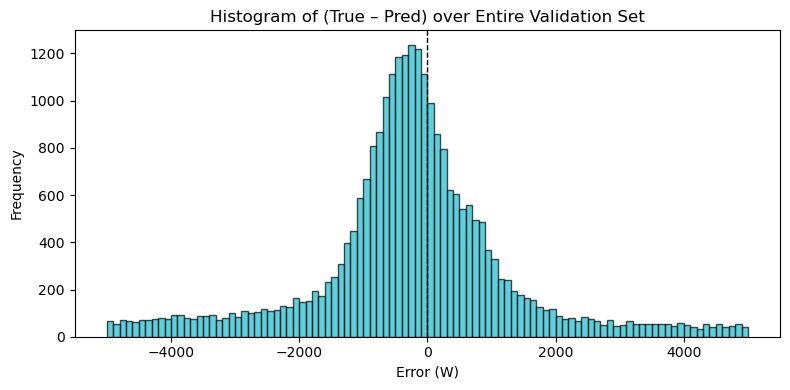

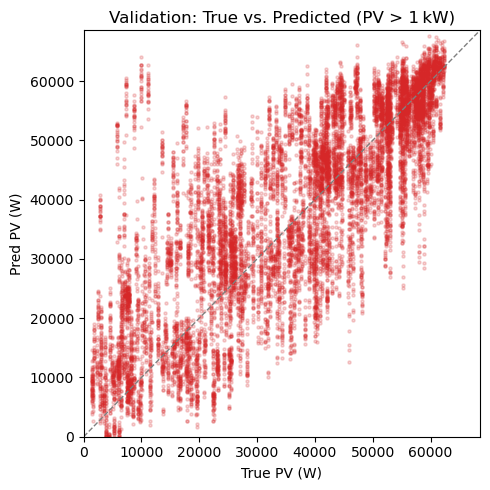

In [63]:
# ─── Cell 16 (updated): Distribution of validation errors (last 1000 points) ─────────────

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# At this point you should already have:
#   - y_val (shape [n_val, 24]) from earlier cells
#   - scaler_y
#   - model

# 16.1) Run a full “validation‐set inference” to collect errors over all 24 h blocks:
y_pred_val_all = model.predict(X_val.astype("float32"))  
#    → shape (n_val, 24, 3) if a quantile model, or (n_val, 24) if a point model

# If it’s a quantile model with three channels (q25, q50, q75), extract the median (50%) slice:
if y_pred_val_all.ndim == 3 and y_pred_val_all.shape[2] == 3:
    y_pred_val_med = y_pred_val_all[:, :, 1]        # shape (n_val, 24)
else:
    # Otherwise assume it's already (n_val, 24)
    y_pred_val_med = y_pred_val_all.reshape(y_pred_val_all.shape[0], y_pred_val_all.shape[1])

# 16.2) Inverse‐scale the 2D “(n_val, 24)” arrays back to Watts:
y_pred_val = scaler_y.inverse_transform(y_pred_val_med)  # shape (n_val, 24)
y_true_val = scaler_y.inverse_transform(y_val)            # shape (n_val, 24)

# 16.3) Flatten to 1‑D arrays so we can pool “all 24 h errors”:
y_pred_all = y_pred_val.ravel()   # length = n_val * 24
y_true_all = y_true_val.ravel()   # same length
errors_all = y_true_all - y_pred_all  # (true minus predicted)

# 16.4) Compute overall metrics over the entire validation set
rmse_all = np.sqrt(np.mean(errors_all**2))
mae_all  = np.mean(np.abs(errors_all))
print(f"ALL‑validation errors (all t+1…t+24):  RMSE = {rmse_all:.1f} W,  MAE = {mae_all:.1f} W")

# 16.5) Plot histogram of the error distribution (clip extreme outliers for visibility)
plt.figure(figsize=(8, 4))
plt.hist(errors_all, bins=100, range=(-5000, 5000), color="tab:cyan", edgecolor="k", alpha=0.7)
plt.axvline(0, color="k", lw=1, linestyle="--")
plt.title("Histogram of (True – Pred) over Entire Validation Set")
plt.xlabel("Error (W)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 16.6) (Optional) Scatter “True vs. Pred (zoom on daytime)” to inspect bias
daytime_mask = y_true_all > 1000.0  # only include points where true PV > 1000 W
plt.figure(figsize=(5, 5))
plt.scatter(
    y_true_all[daytime_mask],
    y_pred_all[daytime_mask],
    s=5,
    alpha=0.2,
    color="tab:red"
)
maxval = y_true_all[daytime_mask].max() * 1.1
plt.plot([0, maxval], [0, maxval], "--", color="gray", lw=1)
plt.xlabel("True PV (W)")
plt.ylabel("Pred PV (W)")
plt.title("Validation: True vs. Predicted (PV > 1 kW)")
plt.xlim(0, maxval)
plt.ylim(0, maxval)
plt.tight_layout()
plt.show()


In [64]:

rmse_all = 7421.4
mae_all  = 4039.8

system_capacity = 84_000  # Watts

rmse_pct = rmse_all / system_capacity * 100
mae_pct  = mae_all  / system_capacity * 100

print(f"RMSE = {rmse_all:.1f} W  →  {rmse_pct:.2f}% of 84 kW")
print(f"MAE  = {mae_all:.1f} W  →  {mae_pct:.2f}% of 84 kW")


RMSE = 7421.4 W  →  8.83% of 84 kW
MAE  = 4039.8 W  →  4.81% of 84 kW


In [65]:
mean_true = np.mean(y_true_all)   # e.g. around 30 000 W (your actual 2023 data)
rmse_norm_by_mean = rmse_all / mean_true * 100
mae_norm_by_mean  = mae_all  / mean_true * 100
print(f"RMSE = {rmse_all:.1f} W → {rmse_norm_by_mean:.2f}% of mean PV")  
print(f"MAE  = {mae_all:.1f} W → {mae_norm_by_mean:.2f}% of mean PV")


RMSE = 7421.4 W → 51.78% of mean PV
MAE  = 4039.8 W → 28.19% of mean PV


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Flattened 24 h RMSE: 7421.4 W   MAE: 4039.8 W


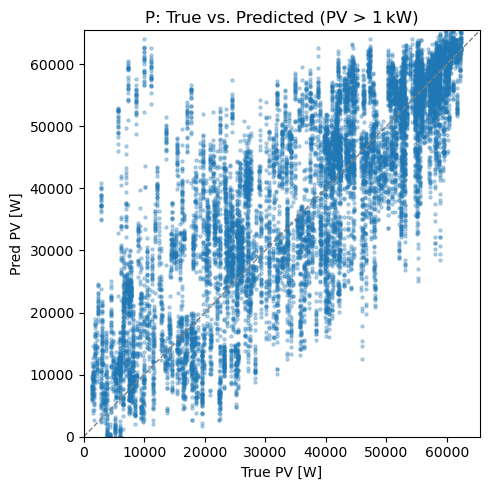

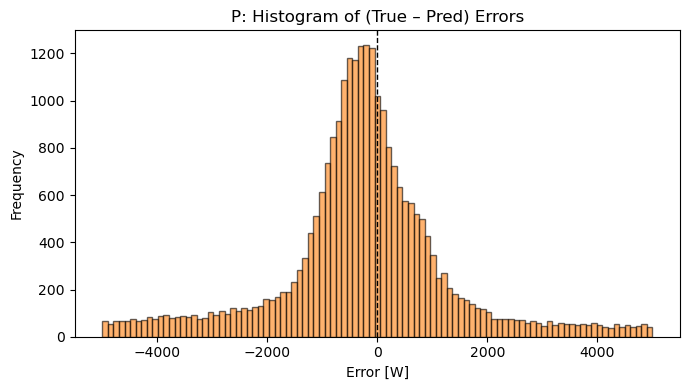

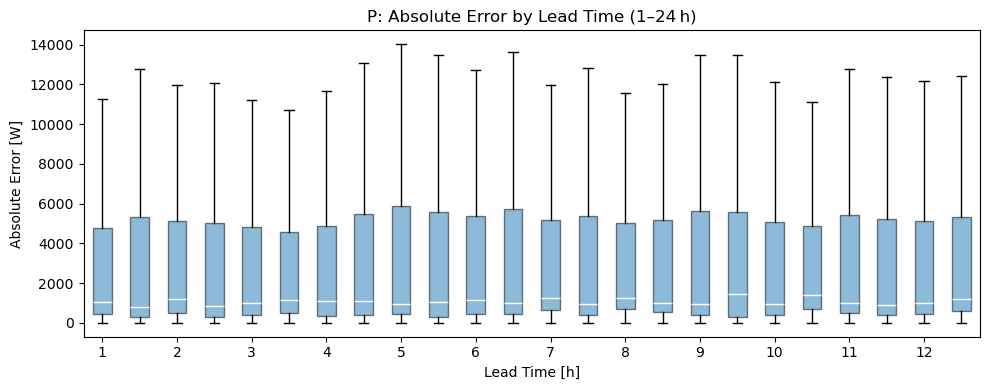

In [69]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Run model.predict on X_val
y_pred_all = model.predict(X_val.astype("float32"))  # shape could be (N_val, 24) or (N_val, 24, 3)

# 2) Determine whether this is a point‐LSTM or quantile‐LSTM:
if y_pred_all.ndim == 3 and y_pred_all.shape[2] == 3:
    # Quantile LSTM: extract median (50% quantile) as the point forecast
    y_pred_med_scaled = y_pred_all[:, :, 1]            # shape (N_val, 24)
    # Also extract q25 and q75 in case you want to plot the IQR later
    y_pred_q25_scaled = y_pred_all[:, :, 0]
    y_pred_q75_scaled = y_pred_all[:, :, 2]
else:
    # Point LSTM: predictions are already shape (N_val, 24)
    y_pred_med_scaled = y_pred_all.reshape(y_pred_all.shape[0], y_pred_all.shape[1])

# 3) Inverse‐scale to get Watts, flatten to 1D arrays (length = N_val * 24)
y_pred_med_flat = scaler_y.inverse_transform(
    y_pred_med_scaled.reshape(-1, 1)
).ravel()
y_true_flat = scaler_y.inverse_transform(
    y_val.reshape(-1, 1)
).ravel()

# 4) Compute overall RMSE & MAE (flattened over all 24h leads)
rmse_all = np.sqrt(mean_squared_error(y_true_flat, y_pred_med_flat))
mae_all  = mean_absolute_error(y_true_flat, y_pred_med_flat)
print(f"Flattened 24 h RMSE: {rmse_all:.1f} W   MAE: {mae_all:.1f} W")

# 5) Scatter plot: True vs. Pred (daytime only: true PV > 1000 W)
day_mask = y_true_flat > 1000.0
plt.figure(figsize=(5,5))
plt.scatter(
    y_true_flat[day_mask],
    y_pred_med_flat[day_mask],
    s=5,
    alpha=0.3,
    color="tab:blue"
)
maxval = y_true_flat[day_mask].max() * 1.05
plt.plot([0, maxval], [0, maxval], "--", color="gray", lw=1)
plt.title("P: True vs. Predicted (PV > 1 kW)")
plt.xlabel("True PV [W]")
plt.ylabel("Pred PV [W]")
plt.xlim(0, maxval)
plt.ylim(0, maxval)
plt.tight_layout()
plt.show()

# 6) Histogram of (True – Pred) errors over entire validation set (±5000 W)
errors_all = y_true_flat - y_pred_med_flat
plt.figure(figsize=(7,4))
bins = np.linspace(-5000, 5000, 100)
plt.hist(errors_all, bins=bins, alpha=0.6, color="tab:orange", edgecolor="k")
plt.axvline(0, color="k", linestyle="--", lw=1)
plt.title("P: Histogram of (True – Pred) Errors")
plt.xlabel("Error [W]")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 7) Boxplot of absolute error by lead time (1…24 h)
#    First reshape true and pred into (N_val, 24) matrices:
N_val = y_val.shape[0]
y_true_matrix = scaler_y.inverse_transform(
    y_val.reshape(-1, 1)
).reshape(N_val, 24)
y_pred_matrix = scaler_y.inverse_transform(
    y_pred_med_scaled.reshape(-1, 1)
).reshape(N_val, 24)

# Build a list of absolute‐error arrays, one per lead (hours 1–24)
data_by_lead = [
    np.abs(y_true_matrix[:, h] - y_pred_matrix[:, h])
    for h in range(24)
]

plt.figure(figsize=(10,4))
plt.boxplot(
    data_by_lead,
    positions=np.arange(1, 25),
    showfliers=False,
    patch_artist=True,
    boxprops=dict(facecolor="tab:blue", alpha=0.5),
    medianprops=dict(color="white")
)
plt.xlabel("Lead Time [h]")
plt.ylabel("Absolute Error [W]")
plt.title("P: Absolute Error by Lead Time (1–24 h)")
plt.xticks(np.arange(1, 25, 2))  # show every other hour label for readability
plt.tight_layout()
plt.show()
